# 🐶 End-to-end Multil-class Dog Breed Classification¶
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

## 1. Problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data
The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features
Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them)

### Get our workspace ready
* Import TensorFlow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

In [2]:
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.5.0
TF Hub version: 0.12.0
GPU available


## Getting our data ready (turning into Tensors)
With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [3]:
label_csv = pd.read_csv("drive/MyDrive/Dog Vision Tensorflow/labels.csv")
print(label_csv.describe())
print(label_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     a6cfd1852f7821cd0ecf7cf92aff06b3  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
label_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


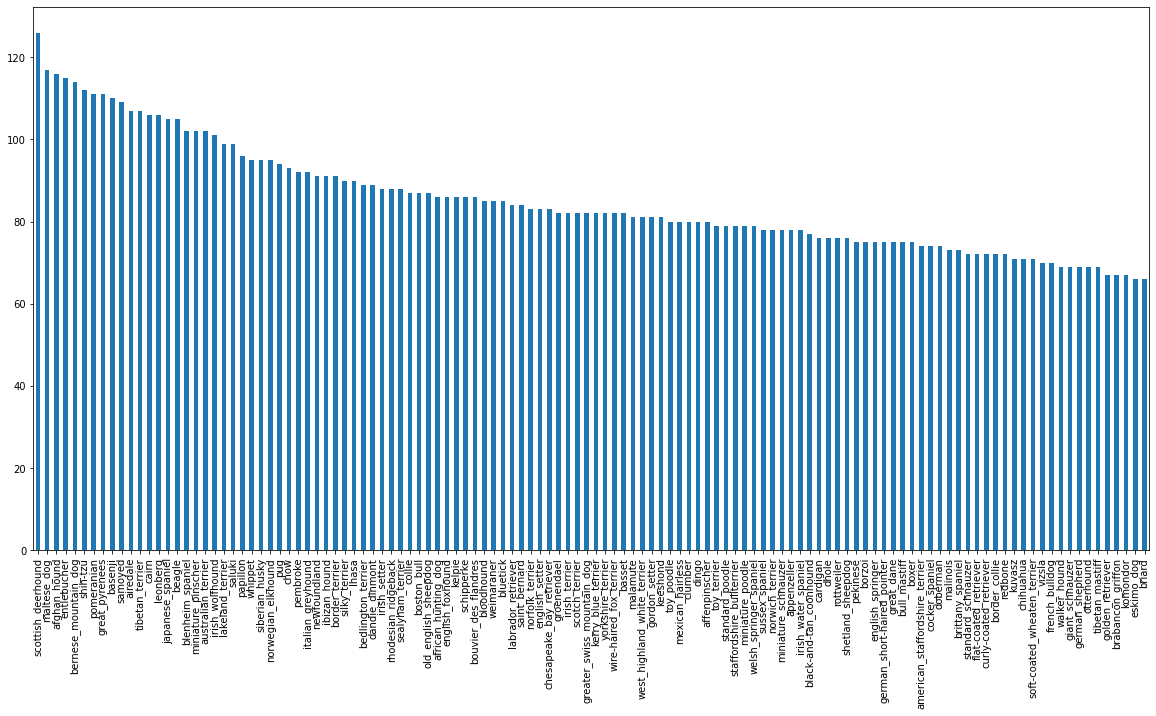

In [5]:
label_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [6]:
label_csv["breed"].value_counts().median()

82.0

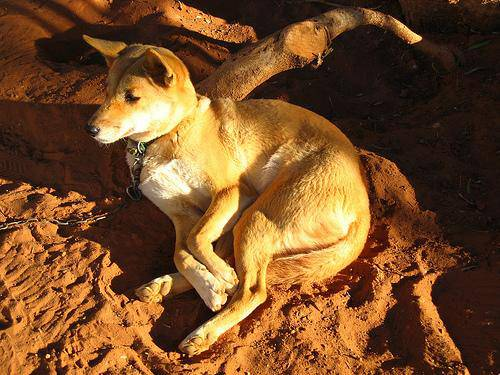

In [7]:
Image("drive/MyDrive/Dog Vision Tensorflow/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels
Let's get a list of all of our image file pathnames.

In [8]:
label_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
filenames = ["drive/MyDrive/Dog Vision Tensorflow/train/"+fname+".jpg" for fname in label_csv["id"]]

filenames

['drive/MyDrive/Dog Vision Tensorflow/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/train/004396df1acd0f1247b740ca2b14616e.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 'dr

In [10]:
import os
if len(os.listdir("drive/MyDrive/Dog Vision Tensorflow/train")) == len(filenames):
  print("Filenames match actual amount of files")
else:
  print("Filename not match actual amount of files, check the target directory")

Filenames match actual amount of files


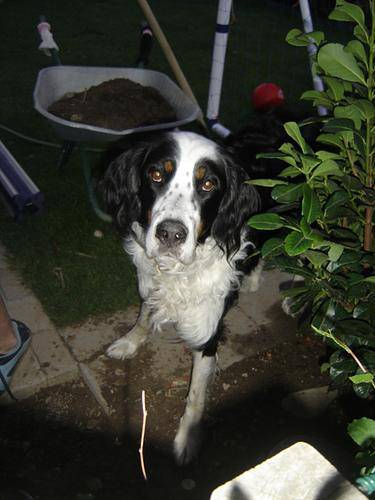

In [11]:
Image(filenames[2000])

In [12]:
print(f"breed name: {label_csv.breed[2000]}")

breed name: appenzeller


Since we've now got our training image filepaths in a list, let's prepare our labels.

In [13]:
labels = label_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels not matches nummber of files, check data directories")

Number of labels matches number of filenames


In [16]:
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [17]:
len(unique_breeds)

120

In [18]:
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [22]:
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [23]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:100}

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

## Preprocessing Images (turning images into Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the image to be a shape of (224, 224)
6. Return the modified image

Before we do, let's see what importing an image looks like.

In [25]:
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [26]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [27]:
image.max(), image.min()

(255, 0)

In [28]:
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5


Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

We'll create a function to:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the image to be a shape of (224, 224)
6. Return the modified image

In [29]:
IMG_SIZE = 224

def process_image(image_path, img_size=IMG_SIZE):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Turning our data into batches
Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (image, label).

In [30]:
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

Now we've got a way to turn our data into tuples of Tensors in the form: (image, label), let's make a function to turn all of our data (X & y) into batches!

In [31]:
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)
  
  return data_batch

In [32]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [33]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches
Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [34]:
def show_25_images(images, labels):
  plt.figure(figsize=(10,10))

  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

In [35]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [36]:
train_images, train_labels = next(train_data.as_numpy_iterator())

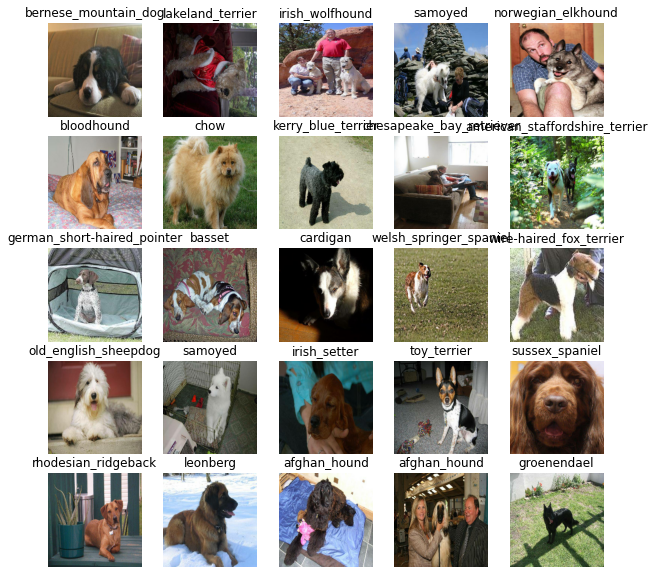

In [37]:
show_25_images(train_images, train_labels)

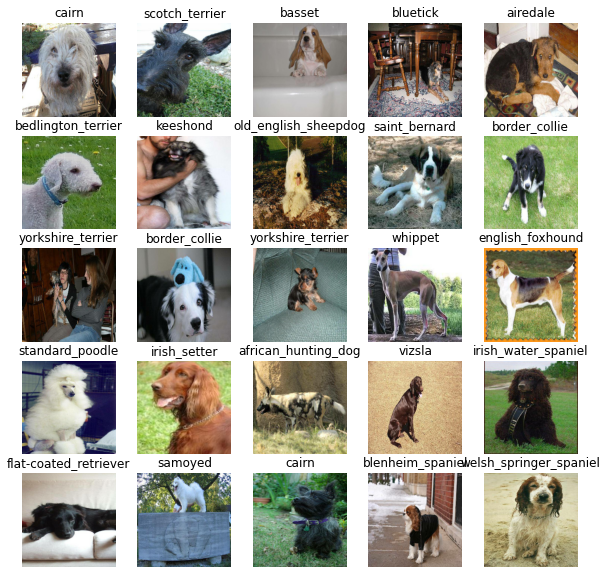

In [38]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model
Before we build a model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [39]:
INPUT_SAHPE = [None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"


Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:

* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [40]:
def create_model(input_shape=INPUT_SAHPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:",  MODEL_URL)
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL),
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax")])
  
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
  model.build(INPUT_SAHPE)
  return model

In [41]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [42]:
outputs = np.ones(shape=(1,1,1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])


## Creating callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback
To setup a TensorBoard callback, we need to do 3 things:

1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function. ✅
3. Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [43]:
%load_ext tensorboard

In [44]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Dog Vision Tensorflow/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)
Our first model is only going to train on 1000 images, to make sure everything is working.

In [46]:
NUM_EPOCHS = 100 #@param {type:"slider", min: 10, max:100, step:10}

In [47]:
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available



Let's create a function which trains a model.

* Create a model using create_model()
* Setup a TensorBoard callback using create_tensorboard_callback()
* Call the fit() function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
* Return the model

In [48]:
def train_model():
  model = create_model()
  tensorboard = create_tensorboard_callback()
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  return model

In [49]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 234s 8s/step - loss: 4.4683 - accuracy: 0.1037 - val_loss: 3.4335 - val_accuracy: 0.2450
Epoch 2/100
25/25 [==============================] - 4s 158ms/step - loss: 1.5951 - accuracy: 0.6875 - val_loss: 2.1328 - val_accuracy: 0.4900
Epoch 3/100
25/25 [==============================] - 4s 158ms/step - loss: 0.5487 - accuracy: 0.9475 - val_loss: 1.6680 - val_accuracy: 0.6000
Epoch 4/100
25/25 [==============================] - 4s 157ms/step - loss: 0.2498 - accuracy: 0.9875 - val_loss: 1.4813 - val_accuracy: 0.6400
Epoch 5/100
25/25 [==============================] - 4s 158ms/step - loss: 0.1444 - accuracy: 0.9975 - val_loss: 1.3968 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 4s 156ms/step - loss: 0.0998 - accuracy: 0.9987 - val_loss: 1.3579 - val_accuracy: 0.6500
Epoch 7/100
25/25 [==============================]

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing! It means our model is learning!!!

### Checking the TensorBoard logs
The TensorBoard magic function (%tensorboard) will access the logs directory we created earlier and visualize its contents.

In [50]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision\ Tensorflow/logs

<IPython.core.display.Javascript object>

## Making and evaluating predictions using a trained model

In [51]:
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 117ms/step


array([[1.8788642e-03, 8.6279506e-05, 6.9441055e-03, ..., 1.2165266e-03,
        8.1914222e-06, 9.4397208e-03],
       [3.7732408e-03, 1.3056297e-03, 2.5251264e-02, ..., 1.5636376e-04,
        3.6622272e-03, 3.5292722e-04],
       [6.4765339e-07, 6.9986381e-05, 1.6887931e-05, ..., 3.2498578e-05,
        4.4611974e-05, 4.0282196e-04],
       ...,
       [1.8211369e-06, 1.1985503e-04, 1.3242397e-04, ..., 1.5705687e-05,
        3.8216688e-04, 2.6273011e-04],
       [1.3301129e-02, 2.5363825e-04, 1.5446254e-04, ..., 5.7050351e-05,
        2.2941496e-05, 5.6013158e-03],
       [3.1176201e-05, 7.0282527e-05, 1.3475219e-03, ..., 9.1888625e-03,
        1.0073442e-04, 3.2233951e-05]], dtype=float32)

In [52]:
predictions.shape

(200, 120)

In [53]:
predictions[0]

array([1.87886425e-03, 8.62795059e-05, 6.94410549e-03, 1.34722082e-04,
       2.69151147e-04, 5.35225772e-05, 3.54736410e-02, 7.60186696e-04,
       4.92724997e-04, 4.05368366e-04, 2.20135320e-04, 1.67883653e-03,
       6.95176481e-04, 2.49123143e-04, 4.59102535e-04, 1.42581039e-03,
       5.47559430e-05, 9.41275880e-02, 4.55642512e-05, 6.78571305e-05,
       2.96299602e-03, 4.20240598e-04, 1.66471713e-04, 7.08563137e-04,
       4.67444333e-05, 1.55354152e-04, 1.24409504e-01, 1.02985854e-04,
       1.52317225e-03, 1.45554674e-04, 6.46348810e-04, 1.07959192e-03,
       4.63922828e-04, 6.50310540e-05, 6.41063525e-05, 9.28401574e-03,
       4.79480514e-05, 4.37893439e-04, 3.11811200e-05, 2.18988280e-04,
       3.23709776e-03, 1.76507656e-05, 1.56093505e-04, 1.88266829e-04,
       7.71208870e-05, 6.27057743e-05, 2.55735140e-05, 5.32068196e-04,
       2.25501426e-04, 4.08641034e-04, 2.25706026e-04, 1.35955910e-04,
       6.74282084e-04, 3.08455608e-04, 1.17974421e-04, 8.45928807e-05,
      

In [54]:
np.sum(predictions[0])

1.0

In [59]:
index = 9
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.13169932e-04 1.70542963e-03 8.47300616e-05 8.24165472e-05
 2.29446986e-03 5.63649833e-03 6.24395208e-03 5.00015868e-03
 2.20345046e-05 1.50503853e-04 1.55340007e-04 4.49341629e-03
 5.91048192e-05 1.07461470e-03 8.45831644e-04 1.09400204e-03
 1.26089798e-02 8.63394453e-05 1.13073387e-03 8.30976584e-04
 2.38936955e-05 3.52000090e-04 1.55148482e-05 2.64442409e-04
 1.20647496e-03 8.23488284e-04 3.64218286e-05 8.68821051e-04
 1.93687680e-04 1.36887975e-04 1.20405958e-03 3.74984200e-04
 1.87523756e-03 6.52152061e-01 4.58829832e-04 7.13803529e-05
 4.11027315e-04 1.31068262e-03 2.25242649e-04 1.77767113e-04
 4.05614916e-03 7.63976495e-05 2.43126303e-02 2.13761046e-03
 1.36309501e-03 4.66399724e-05 3.11852695e-04 3.00916436e-04
 8.50479410e-04 5.23593742e-03 2.22745482e-04 2.35781612e-04
 1.41365528e-02 1.37574010e-04 1.60345845e-02 1.85039849e-03
 3.05054535e-04 5.88762487e-05 4.91130457e-04 1.10531074e-03
 3.42410465e-04 3.18598887e-03 4.42031538e-04 1.10061211e-03
 3.23891931e-04 3.927545

In [57]:
unique_breeds[9]

'beagle'

Having the the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [60]:
def get_pred_label(prediction_probabilities):
  return unique_breeds[np.argmax(prediction_probabilities)]

pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [67]:
# images_ = []
# labels_ = []

# for image, label in val_data.unbatch().as_numpy_iterator():
#   images_.append(image)
#   labels_.append(label)

# images_[0], labels_[0]

In [64]:
get_pred_label(labels_[0])

'cairn'

In [65]:
get_pred_label(predictions[0])

'soft-coated_wheaten_terrier'

In [76]:
def unbatchify(data):
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  
  return images, labels

val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get get:

* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visaulize.

We'll create a function which:

* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [85]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  pred_label = get_pred_label(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title(f"{pred_label} {np.max(pred_prob)*100:2.0f}% {true_label}", color=color)

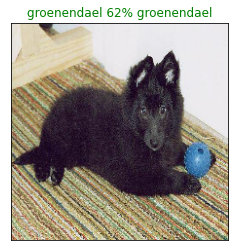

In [88]:
plot_pred(predictions,
          val_labels,
          val_images,
          77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:

* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using get_pred_label() ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [91]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  pred_prob, true_label = prediction_probabilities[n], labels[n]
  pred_label = get_pred_label(pred_prob)

  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

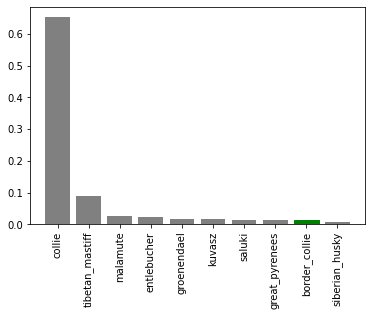

In [92]:
plot_pred_conf(predictions, val_labels, 9)

Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.

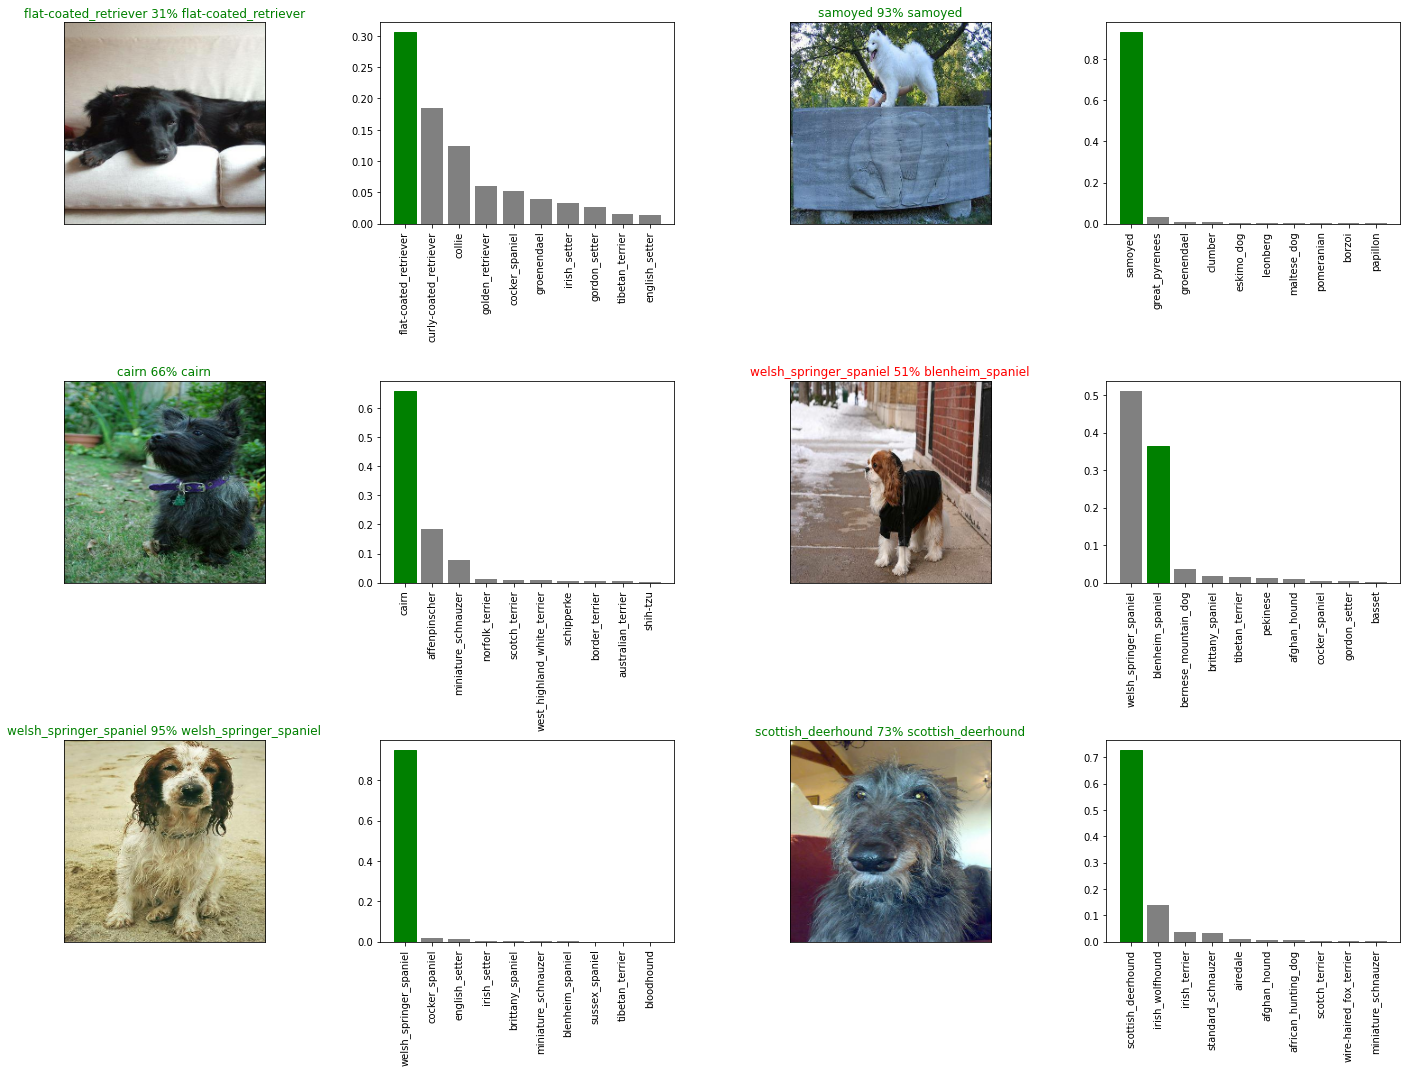

In [95]:
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true labels?

## Saving and reloading a trained model

In [96]:
def save_model(model, suffix=None):
  modeldir = os.path.join("drive/MyDrive/Dog Vision Tensorflow/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  model_path = modeldir + "-" + suffix + ".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [97]:
def load_model(model_path):
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [98]:
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Vision Tensorflow/models/20210611-104800-1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision Tensorflow/models/20210611-104800-1000-images-mobilenetv2-Adam.h5'

In [99]:
loaded_1000_image_model = load_model("drive/MyDrive/Dog Vision Tensorflow/models/20210611-104800-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Vision Tensorflow/models/20210611-104800-1000-images-mobilenetv2-Adam.h5


In [100]:
model.evaluate(val_data)

7/7 [==============================] - 1s 119ms/step - loss: 1.2318 - accuracy: 0.6800


[1.2317837476730347, 0.6800000071525574]

In [101]:
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 112ms/step - loss: 1.2318 - accuracy: 0.6800


[1.2317837476730347, 0.6800000071525574]

## Training a big dog model 🐶 (on the full data)

In [102]:
len(X), len(y)

(10222, 10222)

In [104]:
full_data = create_data_batches(X, y)

Creating training data batches...


In [105]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [106]:
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [107]:
full_model_tensorboard = create_tensorboard_callback()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while (maybe up to 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [108]:
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 2112s 7s/step - loss: 1.3298 - accuracy: 0.6661
Epoch 2/100
320/320 [==============================] - 39s 122ms/step - loss: 0.4002 - accuracy: 0.8818
Epoch 3/100
320/320 [==============================] - 39s 123ms/step - loss: 0.2333 - accuracy: 0.9376
Epoch 4/100
320/320 [==============================] - 39s 123ms/step - loss: 0.1524 - accuracy: 0.9631
Epoch 5/100
320/320 [==============================] - 39s 121ms/step - loss: 0.1062 - accuracy: 0.9781
Epoch 6/100
320/320 [==============================] - 39s 121ms/step - loss: 0.0776 - accuracy: 0.9872
Epoch 7/100
320/320 [==============================] - 39s 120ms/step - loss: 0.0597 - accuracy: 0.9902
Epoch 8/100
320/320 [==============================] - 38s 120ms/step - loss: 0.0463 - accuracy: 0.9932
Epoch 9/100
320/320 [==============================] - 39s 122ms/step - loss: 0.0369 - accuracy: 0.9958
Epoch 10/100
320/320 [==============================] - 38s 120ms

In [109]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Vision Tensorflow/models/20210611-121439-full-image-set-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision Tensorflow/models/20210611-121439-full-image-set-mobilenetv2-Adam.h5'

In [110]:
loaded_full_model = load_model("drive/MyDrive/Dog Vision Tensorflow/models/20210611-121439-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Vision Tensorflow/models/20210611-121439-full-image-set-mobilenetv2-Adam.h5


## Making predictions on the test dataset
Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created create_data_batches() earlier which can take a list of filenames as input and conver them into Tensor batches.

To make predictions on the test data, we'll:

* Get the test image filenames. ✅
* Convert the filenames into test data batches using create_data_batches() and setting the test_data parameter to True (since the test data doesn't have labels). ✅
* Make a predictions array by passing the test batches to the predict() method called on our model.

In [111]:
test_path = "drive/MyDrive/Dog Vision Tensorflow/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/Dog Vision Tensorflow/test/dd5c5652d5d34e922af98c9b0295d909.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/test/de4223b8c5ca7b80d34d1cd2b5e62351.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/test/e57820007fcc2a07a5230177965a0f59.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/test/e63da7cff68f6a5e452bb73cdbd93ad3.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/test/e0e3eb01e80b1d694a47b23909e158ec.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/test/df38352b1f41c92d6750b87b55488ed4.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/test/e1a777d181483b0982732fa4128df7f8.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/test/e1ada9b155a5903bc6475255d012f681.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/test/dcfd3463e1d23d51b309b0385292870b.jpg',
 'drive/MyDrive/Dog Vision Tensorflow/test/e7b357150635c250757363718e4dae86.jpg']

In [112]:
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [113]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling predict() on our full model and passing it the test data batch will take a long time to run (about a ~1hr). This is because we have to process ~10,000+ images and get our model to find patterns in those images and generate predictions based on what its learned in the training dataset.

In [114]:
test_prediction = loaded_full_model.predict(test_data,
                                            verbose=1)

324/324 [==============================] - 2359s 7s/step


In [115]:
np.savetxt("drive/MyDrive/Dog Vision Tensorflow/preds_array.csv", test_prediction, delimiter=",")

In [116]:
test_predictions = np.loadtxt("drive/MyDrive/Dog Vision Tensorflow/preds_array.csv", delimiter=",")

In [117]:
test_predictions[:10]

array([[3.54791240e-12, 2.00499520e-10, 4.43693665e-07, ...,
        1.02562015e-04, 5.79560462e-11, 5.15371166e-12],
       [2.04137766e-11, 9.82529613e-10, 1.03834409e-05, ...,
        3.26095251e-05, 7.39256066e-05, 5.61614262e-11],
       [1.41464462e-11, 1.76884479e-10, 5.12430159e-13, ...,
        4.65329497e-10, 8.96355629e-11, 9.21457875e-12],
       ...,
       [7.72128530e-08, 8.34819713e-10, 1.43789364e-12, ...,
        8.41810233e-10, 1.25936451e-04, 1.82261351e-06],
       [4.06470586e-11, 9.99766767e-01, 2.42514897e-10, ...,
        3.28638450e-08, 1.84170208e-08, 4.92700325e-09],
       [2.98791224e-06, 5.79422343e-10, 2.56477222e-08, ...,
        9.40118412e-07, 1.20371539e-07, 4.24699392e-05]])

## Preparing test dataset predictions for Kaggle
Looking at the Kaggle sample submission, we find that it wants our models prediction probaiblity outputs in a DataFrame with an ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed. ✅
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [118]:
preds_df = pd.DataFrame(columns=["id"]+list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [120]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [121]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,dd5c5652d5d34e922af98c9b0295d909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,de4223b8c5ca7b80d34d1cd2b5e62351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e57820007fcc2a07a5230177965a0f59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e63da7cff68f6a5e452bb73cdbd93ad3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e0e3eb01e80b1d694a47b23909e158ec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,dd5c5652d5d34e922af98c9b0295d909,3.54791e-12,2.005e-10,4.43694e-07,1.79483e-11,8.41123e-10,1.84611e-11,1.7918e-12,2.97301e-10,1.15914e-09,5.4822e-08,1.81022e-10,4.1233e-11,3.04607e-10,2.6271e-12,1.42141e-09,3.21313e-09,2.08451e-12,1.61313e-10,9.12987e-13,2.24155e-07,9.5549e-10,6.46043e-11,9.92262e-08,2.09619e-09,4.82838e-11,5.09282e-09,2.21354e-06,6.08982e-06,0.000165929,4.35343e-06,4.79052e-13,2.7715e-10,1.48186e-11,1.35793e-07,4.52165e-10,3.99403e-12,7.06302e-08,5.20525e-06,1.81065e-08,...,4.69651e-05,5.8137e-06,2.52569e-10,2.66522e-13,1.50711e-09,1.47369e-07,3.82442e-09,4.21896e-08,5.00278e-06,1.90303e-09,2.62745e-06,5.65357e-11,2.04523e-09,3.79952e-11,1.74542e-09,1.22009e-05,1.5865e-07,1.41497e-09,1.06844e-08,1.21223e-11,7.71431e-08,9.44177e-10,2.54789e-05,4.99722e-09,2.12508e-07,1.02381e-11,4.66871e-07,1.26347e-12,3.93467e-12,5.83728e-09,1.5093e-10,9.11541e-06,6.59104e-08,1.31316e-10,5.90331e-11,1.43512e-14,3.83793e-10,0.000102562,5.7956e-11,5.15371e-12
1,de4223b8c5ca7b80d34d1cd2b5e62351,2.04138e-11,9.8253e-10,1.03834e-05,2.85706e-10,3.58208e-09,1.19212e-07,1.09023e-06,0.000278682,2.46188e-10,6.04271e-11,6.82961e-08,3.31676e-11,7.98917e-06,3.69153e-08,1.18835e-05,3.7992e-07,5.98961e-10,9.75879e-07,6.56048e-11,1.17539e-08,6.72246e-09,9.72083e-10,7.39493e-08,2.14839e-11,1.25361e-10,1.55663e-10,3.72714e-10,2.56225e-07,1.13768e-07,1.00633e-05,2.03442e-08,1.40496e-10,8.61385e-11,2.86613e-09,2.71736e-07,1.96809e-10,0.15258,0.83337,3.10472e-10,...,1.22647e-08,2.37694e-07,4.45702e-10,2.19268e-10,3.50914e-09,8.05077e-10,2.2029e-07,3.41875e-11,9.77278e-10,0.00557566,0.00105066,4.80621e-10,4.11404e-13,4.44268e-08,1.51669e-09,2.36257e-10,1.94103e-09,2.39154e-08,3.0281e-09,5.45574e-10,9.39414e-09,3.60885e-10,2.93556e-07,1.14239e-09,0.000216749,2.66058e-09,1.96019e-09,6.15003e-10,4.64047e-10,3.64652e-10,1.75076e-08,0.000264699,7.08657e-09,1.02862e-08,1.0153e-09,6.98616e-09,8.21285e-10,3.26095e-05,7.39256e-05,5.61614e-11
2,e57820007fcc2a07a5230177965a0f59,1.41464e-11,1.76884e-10,5.1243e-13,9.70464e-11,1.42505e-10,1.62573e-10,6.044e-11,8.53326e-10,3.33515e-08,5.37822e-12,1.44249e-11,7.82026e-11,9.21944e-14,1.66987e-05,3.14926e-13,1.60921e-11,8.80767e-11,5.06731e-12,1.54332e-07,1.53837e-12,1.5093e-12,1.29169e-11,1.39153e-12,1.46037e-12,0.000113614,7.70399e-11,1.82286e-10,1.66291e-10,3.84628e-10,1.46385e-12,3.92146e-11,6.25554e-08,3.51777e-08,4.15531e-09,7.51828e-12,1.00308e-11,2.60587e-11,1.54293e-12,1.27718e-10,...,7.97742e-13,1.78483e-10,3.63335e-13,8.65628e-11,9.32022e-10,6.40272e-13,2.82797e-12,7.86611e-13,4.53178e-12,4.57879e-10,5.87309e-12,1.22009e-13,1.05971e-06,3.47736e-09,1.62893e-10,1.68525e-14,1.87548e-10,2.08896e-11,1.05498e-11,2.98634e-11,9.23479e-09,2.20892e-10,2.96239e-11,4.91854e-10,2.57391e-12,4.55423e-09,2.54909e-10,1.8711e-09,2.21094e-12,7.22603e-11,3.12687e-13,1.26627e-12,4.79537e-13,2.94284e-09,2.56142e-11,0.999859,1.21067e-09,4

In [123]:
preds_df.to_csv("drive/MyDrive/Dog Vision Tensorflow/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images
To make predictions on custom images, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [126]:
custom_path = "drive/MyDrive/Dog Vision Tensorflow/my-dogs-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [128]:
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [129]:
custom_preds = loaded_full_model.predict(custom_data)

In [130]:
custom_preds.shape

(3, 120)

In [131]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['malamute', 'chihuahua', 'french_bulldog']

In [132]:
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

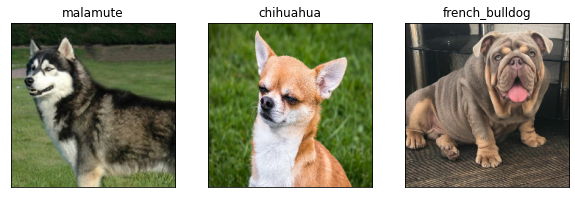

In [133]:
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)